In [7]:
import os
import pandas as pd
import tensorflow as tf

def load_data(data_path):
    data = [(label, os.path.join(data_path, label, image))
        for label in os.listdir(data_path)
        if os.path.isdir(os.path.join(data_path, label))
        for image in os.listdir(os.path.join(data_path, label))]
    return pd.DataFrame(data, columns=['Class', 'Class Path'])

train = load_data('mri-data')
test = load_data('mri-test')


In [8]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train, train_size=0.9, random_state=42, stratify=train['Class'])

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

test_data = ImageDataGenerator(rescale=1./255)

train_generator = train_data.flow_from_dataframe(
    train,
    x_col='Class Path',
    y_col='Class',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = test_data.flow_from_dataframe(
    valid,
    x_col='Class Path',
    y_col='Class',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_data.flow_from_dataframe(
    test,
    x_col='Class Path',
    y_col='Class',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

Found 12456 validated image filenames belonging to 4 classes.
Found 1385 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


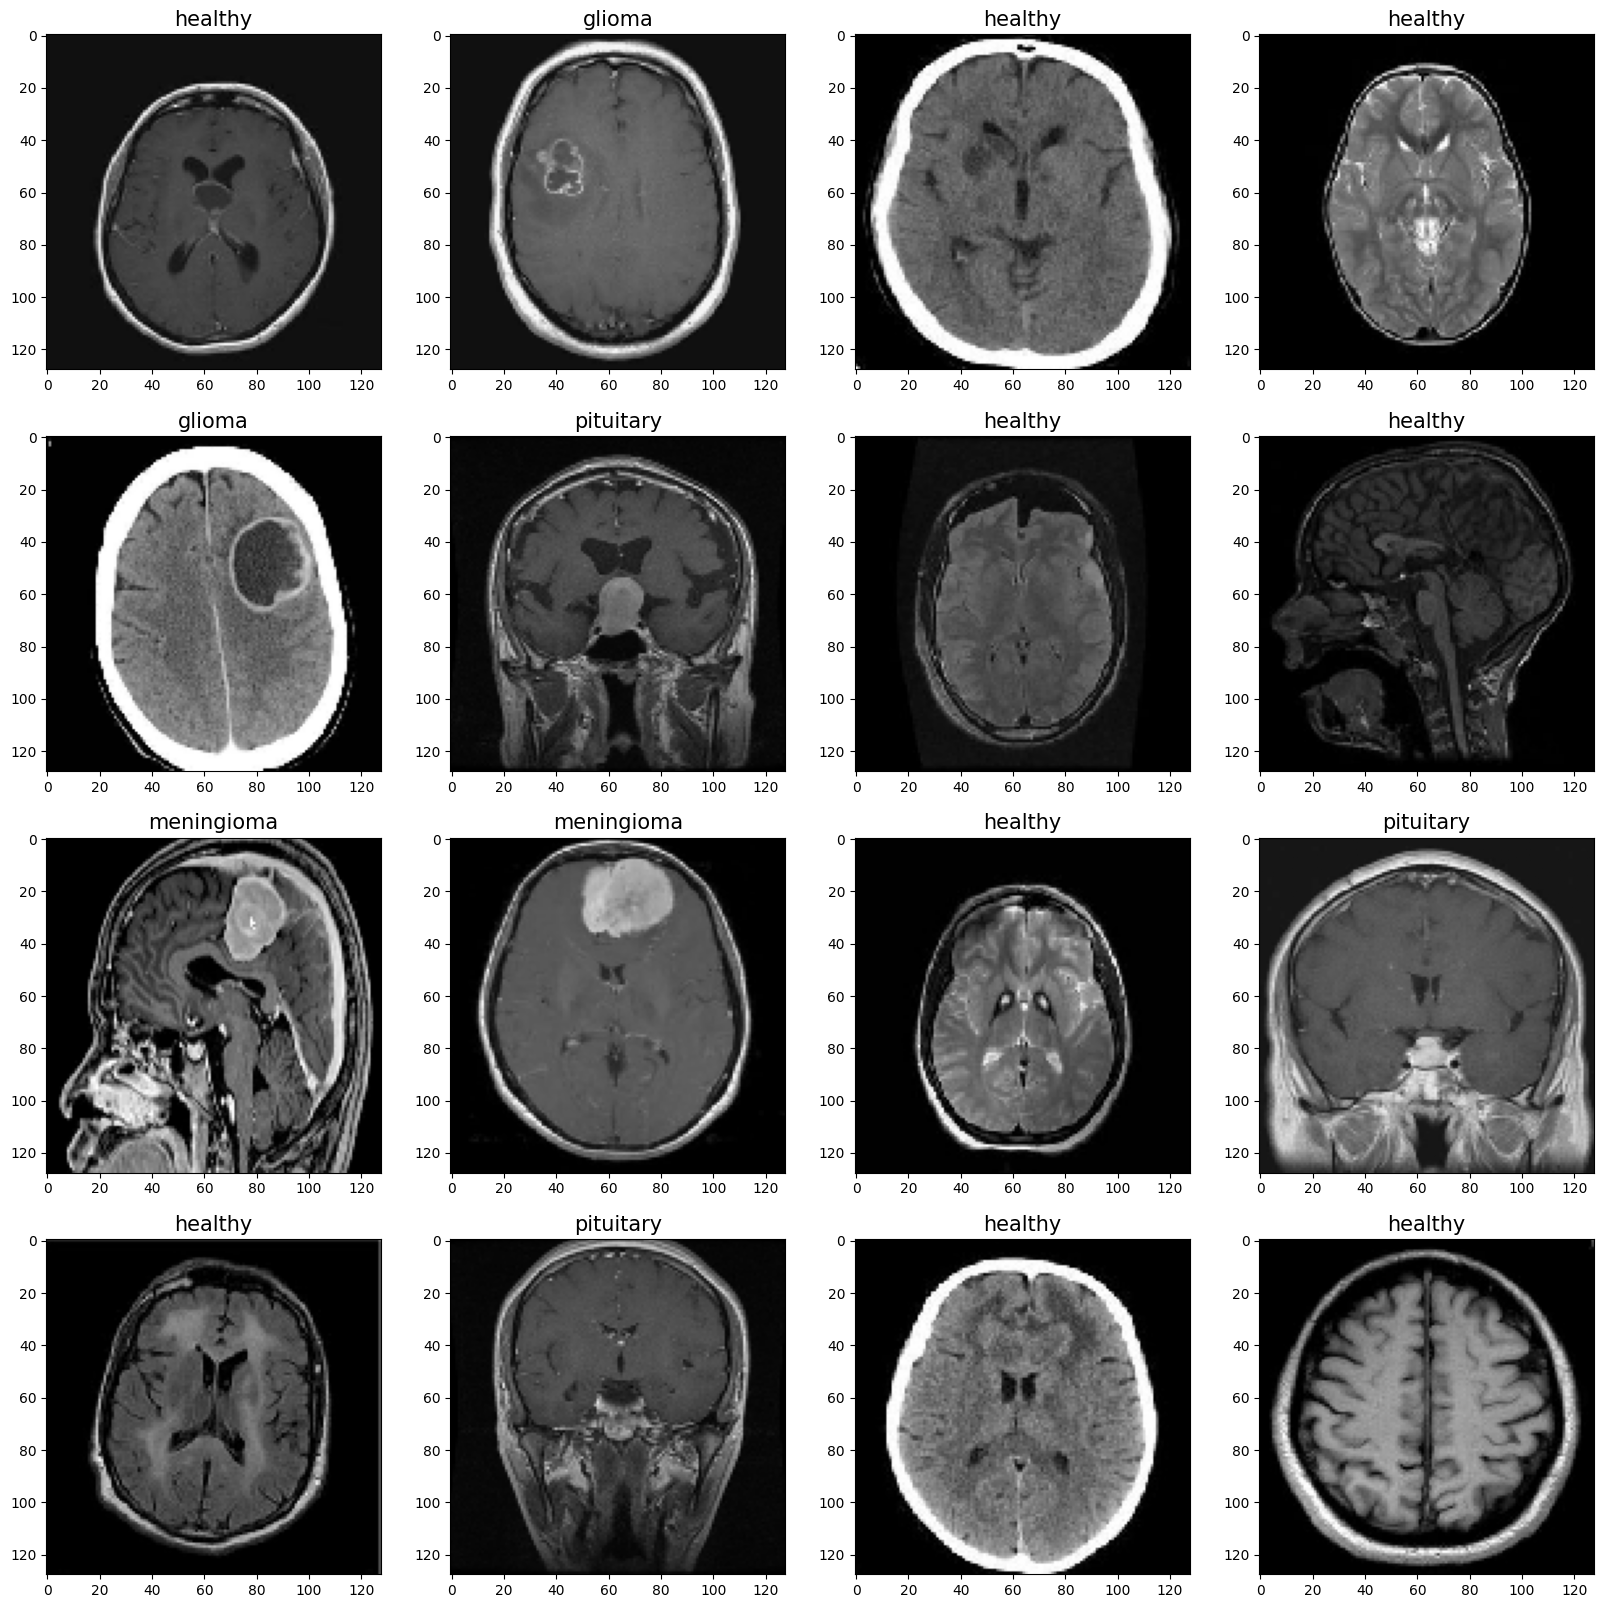

In [16]:
import matplotlib.pyplot as plt
import numpy as np

class_dict = train_generator.class_indices
classes = list(class_dict.keys())
images, labels = next(test_generator)

plt.figure(figsize=(20,20))

for i in range(min(len(images), 16)):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i])
    class_name = classes[np.argmax(labels[i])]
    plt.title(class_name, fontsize=15)

plt.show()

In [10]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential

img_shape=(128,128)

base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(128,128,3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 4, 4, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 20,815,148 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [12]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator, shuffle=False)

Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 273s 675ms/step - accuracy: 0.9260 - loss: 0.2294 - val_accuracy: 0.9603 - val_loss: 0.0985
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 266s 682ms/step - accuracy: 0.9761 - loss: 0.0831 - val_accuracy: 0.9704 - val_loss: 0.1104
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 266s 683ms/step - accuracy: 0.9799 - loss: 0.0660 - val_accuracy: 0.8801 - val_loss: 0.5152
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 266s 683ms/step - accuracy: 0.9864 - loss: 0.0471 - val_accuracy: 0.9827 - val_loss: 0.0752
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 265s 680ms/step - accuracy: 0.9834 - loss: 0.0542 - val_accuracy: 0.9942 - val_loss: 0.0195
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 266s 681ms/step - accuracy: 0.9939 - loss: 0.0204 - val_accuracy: 0.4823 - val_loss: 4.6926
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 261s 670ms/step - accuracy: 0.9850 - loss: 0.0486 - val_accuracy: 0.9776 - val_loss: 0.0635
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 263s 673ms/step - accuracy: 0.9925 -

In [18]:
train_score = model.evaluate(train_generator, verbose=1)
valid_score = model.evaluate(val_generator, verbose=1)
test_score = model.evaluate(test_generator, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Valid Loss: {valid_score[0]:.4f}")
print(f"Valid Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.9782 - loss: 0.0842
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9711 - loss: 0.0857
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.7920 - loss: 0.9672 
Train Loss: 0.0842
Train Accuracy: 97.82%
--------------------
Valid Loss: 0.0857
Valid Accuracy: 97.11%
--------------------
Test Loss: 0.9672
Test Accuracy: 79.20%


In [19]:
predictions = model.predict(test_generator)
y_predictions=np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step 


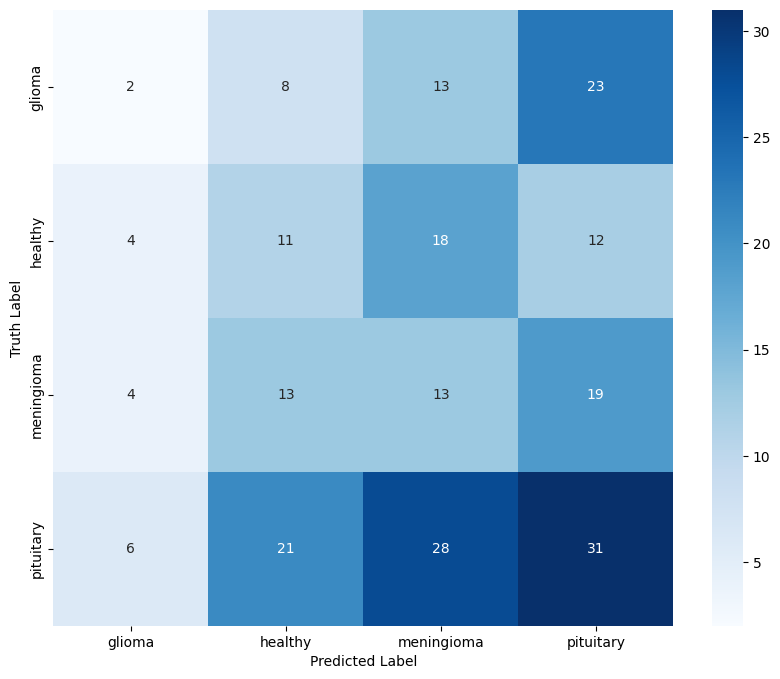

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_generator.classes, y_predictions)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("Truth Label")
plt.show()

In [22]:
clr = classification_report(test_generator.classes, y_predictions)
print(clr)

              precision    recall  f1-score   support

           0       0.12      0.04      0.06        46
           1       0.21      0.24      0.22        45
           2       0.18      0.27      0.21        49
           3       0.36      0.36      0.36        86

    accuracy                           0.25       226
   macro avg       0.22      0.23      0.22       226
weighted avg       0.24      0.25      0.24       226

